This example notebook shows how to run the SRI MAPER code with a Masked Auto Encoder backbone.

In [1]:
from sri_maper.src.utils import build_hydra_config_notebook, print_config_tree
from sri_maper.src.pretrain import pretrain
from sri_maper.src.train import train
from sri_maper.src.test import test
from sri_maper.src.map import build_map
from torch import set_float32_matmul_precision

set_float32_matmul_precision('medium') # reduces floating point precision for computational efficiency

First we'll define the "experiment config". An experiment config (short for configuration) defines all changable parameters for the experiment. This includes data parameters (e.g. raster stack to use), model parameters (e.g. backbone architecture), training parameters (e.g. GPU vs CPU training), mapping parameters (e.g. number of monte-carlo samples), and others. [Hydra](https://hydra.cc/) is the open-soure hierarchical experiment configuration library we use to implement our experiment configuration. Please supplement our instructions / guidance with [Hydra's documentation](https://hydra.cc/docs/intro/).

As an example, below we load the config for the national-scale Magmatic Nickel challeng (MaNiAC) presented at Hackathon 2.

In [2]:
pretrain_cfg = build_hydra_config_notebook(
    overrides=[
        "experiment=exp_maniac_maevit_pretrain_l22_uscont",
        "trainer=gpu"
    ]
)
print_config_tree(pretrain_cfg)

CONFIG
├── data
│   └── _target_: sri_maper.src.data.tiff_datamodule.TIFFDataModule                                                
│       tif_dir: ${paths.data_dir}/H3_dilation_5/MaNiAC                                                            
│       window_size: 5                                                                                             
│       multiplier: 20                                                                                             
│       downsample: false                                                                                          
│       oversample: false                                                                                          
│       likely_neg_range:                                                                                          
│       - 0.25                                                                                                     
│       - 0.75                                                                                                     
│       batch_size: 1024                                                                                           
│       num_workers: 12                                                                                            
│       pin_memory: false                                                                                          
│       seed: ${seed}                                                                                              
│       log_path: ${paths.output_dir}                                                                              
│                                                                                                                  
├── model
│   └── _target_: sri_maper.src.models.cma_module_pretrain_mae.SSCMALitModule                                      
│       optimizer:                                                                                                 
│         _target_: torch.optim.AdamW                                                                              
│         _partial_: true                                                                                          
│         lr: 0.001                                                                                                
│         weight_decay: 0.01                                                                                       
│       scheduler:                                                                                                 
│         _target_: torch.optim.lr_scheduler.ReduceLROnPlateau                                                     
│         _partial_: true                                                                                          
│         mode: min                                                                                                
│         factor: 0.1                                                                                              
│         patience: 10                                                                                             
│       net:                                                                                                       
│         _target_: sri_maper.src.models.mae_vit.MAE_ViT                                                           
│         image_size: ${data.window_size}                                                                          
│         patch_size: 1                                                                                            
│         input_dim: 14                                                                                            
│         enc_dim: 256                                                                                             
│         encoder_layer: 6                                                                                         
│         encoder_head: 8     

The config above is used to pretrain for the MaNiAC raster stack. In the case of pretraining, the same config can be used for any deposit that uses the same evidence layers in the same order. This possible because the pretrained backbone is used to extract generic features that get finetuned per deposit type (i.e. like a foundation model for that set of evidence layers). Changing the config for another raster stack that exists in our repo (e.g. the set of rasters in the Lawley'22 datacube) is as easy as changing a single paramter. Simply modify the "experiment" variable above with the overrides to a different raster stack [experiment](../configs/experiment/). Current MAE experiment pretrain configs available are:
* exp_maniac_maevit_pretrain_l22_uscont
* exp_maevit_pretrain_l22_uscont

Now we can use the generated config file to run the experiment. We pass this config file to the [pretrain task](../src/pretrain.py), which returns metrics and objects created during the run.

In [3]:
pretrain_metrics, pretrain_objs = pretrain(pretrain_cfg)

Global seed set to 1234
100%|██████████| 1/1 [00:00<00:00, 775.14it/s]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
wandb: Currently logged in as: adaruna3. Use `wandb login --relogin` to force relogin


Using 16bit None Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     ┃ Name                                  ┃ Type                             ┃ Params ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0   │ net                                   │ MAE_ViT                          │  5.2 M │
│ 1   │ net.encoder                           │ MAE_Encoder                      │  4.7 M │
│ 2   │ net.encoder.patch_embedding           │ Sequential                       │  3.8 K │
│ 3   │ net.encoder.patch_embedding.0         │ Conv2d                           │  3.8 K │
│ 4   │ net.encoder.patch_embedding.1         │ Flatten                          │      0 │
│ 5   │ net.encoder.patch_drop                │ PatchDropLayer                   │      0 │
│ 6   │ net.encoder.backbone                  │ Sequential                       │  4.7 M │
│ 7   │ net.encoder.backbone.0                │ Block                            │  788 K │
│ 8   │ net.encoder.backbone.0.norm1          │ LayerNorm                        │    512 │
│ 9   │ net.encoder.backbone.0.attn           │ Attention                        │  262 K │
│ 10  │ net.encoder.backbone.0.attn.qkv       │ Linear                           │  196 K │
│ 11  │ net.encoder.backbone.0.attn.q_norm    │ Identity                         │      0 │
│ 12  │ net.encoder.backbone.0.attn.k_norm    │ Identity                         │      0 │
│ 13  │ net.encoder.backbone.0.attn.attn_drop │ Dropout                          │      0 │
│ 14  │ net.encoder.backbone.0.attn.proj      │ Linear                           │ 65.8 K │
│ 15  │ net.encoder.backbone.0.attn.proj_drop │ Dropout                          │      0 │
│ 16  │ net.encoder.backbone.0.ls1            │ Identity                         │      0 │
│ 17  │ net.encoder.backbone.0.drop_path1     │ Identity                         │      0 │
│ 18  │ net.encoder.backbone.0.norm2          │ LayerNorm                        │    512 │
│ 19  │ net.encoder.backbone.0.mlp            │ Mlp                              │  525 K │
│ 20  │ net.encoder.backbone.0.mlp.fc1        │ Linear                           │  263 K │
│ 21  │ net.encoder.backbone.0.mlp.act        │ GELU                             │      0 │
│ 22  │ net.encoder.backbone.0.mlp.drop1      │ Dropout                          │      0 │
│ 23  │ net.encoder.backbone.0.mlp.norm       │ Identity                         │      0 │
│ 24  │ net.encoder.backbone.0.mlp.fc2        │ Linear                           │  262 K │
│ 25  │ net.encoder.backbone.0.mlp.drop2      │ Dropout                          │      0 │
│ 26  │ net.encoder.backbone.0.ls2            │ Identity                         │      0 │
│ 27  │ net.encoder.backbone.0.drop_path2     │ Identity                         │      0 │
│ 28  │ net.encoder.backbone.1                │ Block                            │  788 K │
│ 29  │ net.encoder.backbone.1.norm1          │ LayerNorm                        │    512 │
│ 30  │ net.encoder.backbone.1.attn           │ Attention                        │  262 K │
│ 31  │ net.encoder.backbone.1.attn.qkv       │ Linear                           │  196 K │
│ 32  │ net.encoder.backbone.1.attn.q_norm    │ Identity                         │      0 │
│ 33  │ net.encoder.backbone.1.attn.k_norm    │ Identity                         │      0 │
│ 34  │ net.encoder.backbone.1.attn.attn_drop │ Dropout                          │      0 │
│ 35  │ net.encoder.backbone.1.attn.proj      │ Linear                           │ 65.8 K │
│ 36  │ net.encoder.backbone.1.attn.proj_drop │ Dropout                          │      0 │
│ 37  │ net.encoder.backbone.1.ls1            │ Identity                         │      0 │
│ 38  │ net.encoder.backbone.1.drop_path1     │ Identity                         │      0 │
│ 39  │ net.encoder.backbone.1.norm2          │ LayerNorm                        │    512 │
│ 40  │ net.encoder.backbone.1.mlp          

Trainable params: 5.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.2 M                                                                                                
Total estimated model params size (MB): 10

Output()

`Trainer.fit` stopped: `max_epochs=30` reached.


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │    0.01604490727186203    │
│         test/psnr         │    34.635860443115234     │
│         test/ssim         │    0.9284635782241821     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test/loss,▁
test/psnr,▁
test/ssim,▁
train/loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val/loss,██▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/psnr,▁▁▅▅▆▆▆▆▆▆▆▆▆▇▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇█
val/psnr_best,▁▁▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████████████████████
val/ssim,▁▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████████████
val/ssim_best,▁▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████████


If pretraining completed successfully, you will see the outputs of all the logging running when pretraining above. By carefully reading through the logs above, you will find where the model checkpoints, logs, and other generated files are stored. These can also be accessed using return values of pretrain above.

Now that we've pretrained the MAE, we can use the pretrained MAE as a backbone to finetune a deposit prospectivity model.

The config used below is for MaNiAC; however, changing the config for another deposit that exists in our repo is as easy as changing a single paramter (and using the correct pretrain backbone that corresponds to that deposit type). Simply modify the "experiment" variable above with the overrides to a different MAE classifier [experiment](../configs/experiment/). Current MAE classifier experiment configs available are:
* exp_maniac_maevit_classifier_l22_uscont
* exp_mvt_maevit_classifier_l22_uscont
* exp_w_maevit_classifier_l22_uscont

Note - the `exp_mvt_maevit_classifier_l22_uscont` and `exp_w_maevit_classifier_l22_uscont` experiment configs use a backbone generated by `exp_maevit_pretrain_l22_uscont`, while `exp_maniac_maevit_classifier_l22_uscont` uses `exp_maniac_maevit_pretrain_l22_uscont`. This is because the national-scale MaNiAC experiments (currently) use a differnt set of evidence layers than the MVT Lead-Zinc or Tungsten-skarn experiments. Soon we plan to train MAEs for each modality / mineral system so modality specific MAEs can be swapped in/out without the need to pretrain if the evidence layers change.

Now we generate a config file to train a classifier for MaNiAC using the pretrained MAE for MaNiAC.

In [4]:
train_cfg = build_hydra_config_notebook(overrides=["experiment=exp_maniac_maevit_classifier_l22_uscont","trainer=gpu"])
train_cfg.model.net.backbone_ckpt = pretrain_objs["trainer"].checkpoint_callback.best_model_path # sets model backbone
print_config_tree(train_cfg)

CONFIG
├── data
│   └── _target_: sri_maper.src.data.tiff_datamodule.TIFFDataModule                                                
│       tif_dir: ${paths.data_dir}/H3_dilation_5/MaNiAC                                                            
│       window_size: 5                                                                                             
│       multiplier: 20                                                                                             
│       downsample: true                                                                                           
│       oversample: true                                                                                           
│       likely_neg_range:                                                                                          
│       - 0.5                                                                                                      
│       - 0.8                                                                                                      
│       batch_size: 32                                                                                             
│       num_workers: 12                                                                                            
│       pin_memory: false                                                                                          
│       seed: ${seed}                                                                                              
│       log_path: ${paths.output_dir}                                                                              
│                                                                                                                  
├── model
│   └── _target_: sri_maper.src.models.cma_module.CMALitModule                                                     
│       optimizer:                                                                                                 
│         _target_: torch.optim.AdamW                                                                              
│         _partial_: true                                                                                          
│         lr: 0.001                                                                                                
│         weight_decay: 0.01                                                                                       
│       scheduler:                                                                                                 
│         _target_: torch.optim.lr_scheduler.ReduceLROnPlateau                                                     
│         _partial_: true                                                                                          
│         mode: min                                                                                                
│         factor: 0.1                                                                                              
│         patience: 10                                                                                             
│       net:                                                                                                       
│         _target_: sri_maper.src.models.mae_vit_classifier.CLSClassifer                                           
│         backbone_ckpt: ../../logs/cmta3-pretrain-maevit/runs/2024-04-09_21-55-24/checkpoints/ssim_0.928.ckpt     
│         backbone_net:                                                                                            
│           _target_: sri_maper.src.models.mae_vit.MAE_ViT                                                         
│           image_size: ${data.window_size}                                                                        
│           patch_size: 1                                                                                          
│           input_dim: 14     

Now we can use the generated config file to run the experiment. We pass this config file to the [train task](../src/train.py), which returns metrics and objects created during the run.

In [5]:
train_metrics, train_objs = train(train_cfg)

Global seed set to 1234
100%|██████████| 1/1 [00:00<00:00, 785.89it/s]


Using 16bit None Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     ┃ Name                                   ┃ Type                   ┃ Params ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0   │ net                                    │ CLSClassifer           │  4.8 M │
│ 1   │ net.backbone                           │ MAE_Encoder            │  4.7 M │
│ 2   │ net.backbone.patch_embedding           │ Sequential             │  3.8 K │
│ 3   │ net.backbone.patch_embedding.0         │ Conv2d                 │  3.8 K │
│ 4   │ net.backbone.patch_embedding.1         │ Flatten                │      0 │
│ 5   │ net.backbone.patch_drop                │ DummyPatchDropLayer    │      0 │
│ 6   │ net.backbone.backbone                  │ Sequential             │  4.7 M │
│ 7   │ net.backbone.backbone.0                │ Block                  │  788 K │
│ 8   │ net.backbone.backbone.0.norm1          │ LayerNorm              │    512 │
│ 9   │ net.backbone.backbone.0.attn           │ Attention              │  262 K │
│ 10  │ net.backbone.backbone.0.attn.qkv       │ Linear                 │  196 K │
│ 11  │ net.backbone.backbone.0.attn.q_norm    │ Identity               │      0 │
│ 12  │ net.backbone.backbone.0.attn.k_norm    │ Identity               │      0 │
│ 13  │ net.backbone.backbone.0.attn.attn_drop │ Dropout                │      0 │
│ 14  │ net.backbone.backbone.0.attn.proj      │ Linear                 │ 65.8 K │
│ 15  │ net.backbone.backbone.0.attn.proj_drop │ Dropout                │      0 │
│ 16  │ net.backbone.backbone.0.ls1            │ Identity               │      0 │
│ 17  │ net.backbone.backbone.0.drop_path1     │ Identity               │      0 │
│ 18  │ net.backbone.backbone.0.norm2          │ LayerNorm              │    512 │
│ 19  │ net.backbone.backbone.0.mlp            │ Mlp                    │  525 K │
│ 20  │ net.backbone.backbone.0.mlp.fc1        │ Linear                 │  263 K │
│ 21  │ net.backbone.backbone.0.mlp.act        │ GELU                   │      0 │
│ 22  │ net.backbone.backbone.0.mlp.drop1      │ Dropout                │      0 │
│ 23  │ net.backbone.backbone.0.mlp.norm       │ Identity               │      0 │
│ 24  │ net.backbone.backbone.0.mlp.fc2        │ Linear                 │  262 K │
│ 25  │ net.backbone.backbone.0.mlp.drop2      │ Dropout                │      0 │
│ 26  │ net.backbone.backbone.0.ls2            │ Identity               │      0 │
│ 27  │ net.backbone.backbone.0.drop_path2     │ Identity               │      0 │
│ 28  │ net.backbone.backbone.1                │ Block                  │  788 K │
│ 29  │ net.backbone.backbone.1.norm1          │ LayerNorm              │    512 │
│ 30  │ net.backbone.backbone.1.attn           │ Attention              │  262 K │
│ 31  │ net.backbone.backbone.1.attn.qkv       │ Linear                 │  196 K │
│ 32  │ net.backbone.backbone.1.attn.q_norm    │ Identity               │      0 │
│ 33  │ net.backbone.backbone.1.attn.k_norm    │ Identity               │      0 │
│ 34  │ net.backbone.backbone.1.attn.attn_drop │ Dropout                │      0 │
│ 35  │ net.backbone.backbone.1.attn.proj      │ Linear                 │ 65.8 K │
│ 36  │ net.backbone.backbone.1.attn.proj_drop │ Dropout                │      0 │
│ 37  │ net.backbone.backbone.1.ls1            │ Identity               │      0 │
│ 38  │ net.backbone.backbone.1.drop_path1     │ Identity               │      0 │
│ 39  │ net.backbone.backbone.1.norm2          │ LayerNorm              │    512 │
│ 40  │ net.backbone.backbone.1.mlp            │ Mlp                    │  525 K │
│ 41  │ net.backbone.backbone.1.mlp.fc1        │ Linear                 │  263 K │
│ 42  │ net.backbone.backbone.1.mlp.act        │ GELU                   │      0 │
│ 43  │ net.backbone.backbone.1.mlp.drop1      │ Dropout                │      0 │
│ 44  │ net.backbone.backbone.1.mlp.norm       │ Identity               │      0 │
│ 45  │ net.back

Trainable params: 41.6 K                                                                                           
Non-trainable params: 4.7 M                                                                                        
Total params: 4.8 M                                                                                                
Total estimated model params size (MB): 9

Output()

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in 
targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...
`Trainer.fit` stopped: `max_epochs=100` reached.


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in 
targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9767801761627197     │
│         test/auc          │    0.9425911903381348     │
│        test/auprc         │    0.8541192412376404     │
│       test/bal_acc        │    0.7580645084381104     │
│          test/f1          │    0.6808510422706604     │
│         test/loss         │    0.5022110939025879     │
│         test/mcc          │    0.7098170518875122     │
│        test/prob1         │    0.10061919689178467    │
│        test/recall        │    0.8709677457809448     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test/acc,▁
test/auc,▁
test/auprc,▁
test/bal_acc,▁
test/f1,▁
test/loss,▁
test/mcc,▁
test/prob1,▁
test/recall,▁
train/loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


If training completed successfully, you will see the outputs of all the logging running when training above. By carefully reading through the logs above, you will find where the model checkpoints, logs, and other generated files are stored. These can also be accessed using return values of train above.

For example, let's test the trained model again using the [test task](../src/test.py). Note - testing is optionally included in the training above and can be disabled by modifying the experiment config.

In [6]:
train_cfg.ckpt_path = train_objs["trainer"].checkpoint_callback.best_model_path # required for test
test_metrics, test_objs = test(train_cfg)

100%|██████████| 1/1 [00:00<00:00, 752.61it/s]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9767801761627197     │
│         test/auc          │    0.9425911903381348     │
│        test/auprc         │    0.8541192412376404     │
│       test/bal_acc        │    0.7580645084381104     │
│          test/f1          │    0.6808510422706604     │
│         test/loss         │    0.5022110939025879     │
│         test/mcc          │    0.7098170518875122     │
│        test/prob1         │    0.10061919689178467    │
│        test/recall        │    0.8709677457809448     │
└───────────────────────────┴───────────────────────────┘

epoch,▁
test/acc,▁
test/auc,▁
test/auprc,▁
test/bal_acc,▁
test/f1,▁
test/loss,▁
test/mcc,▁
test/prob1,▁
test/recall,▁
trainer/global_step,▁


You'll notice the repeated testing shows our experiments / testing are repeatable as all metrics match up to 4 significant figures.

Note, `train`, `test`, and `build_map` (below) all can run individually and with different configs. Below we'll build a map and use a different config to do so, by manipulating the existing one. Below we've elected to use a larger batch size during mapping.

In [7]:
train_cfg.data.batch_size=128
maniac_maps, _ = build_map(train_cfg)

100%|██████████| 1/1 [00:00<00:00, 570.65it/s]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Optionally, we can directly plot these produced maps. For example, below we plot the likelihood. Note - the raw output maps should be re-clipped using the study region bounds (e.g. a vector file) in QGIS.

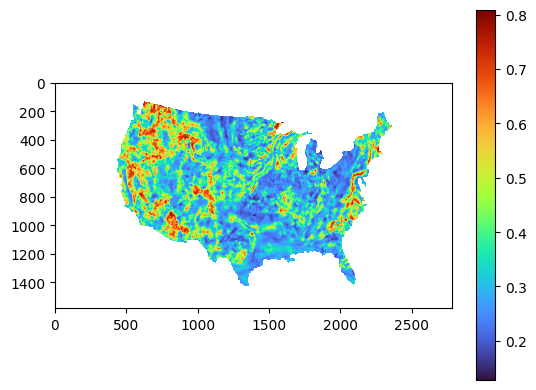

In [8]:
import rasterio
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path

with rasterio.open(maniac_maps[0], "r") as likelihood_raster:
    likelihood_data = likelihood_raster.read(1)
plt.imshow(likelihood_data, cmap="turbo")
plt.colorbar()
plt.show()